<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Laboratorio01_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Laboratorio 2: Tipos de imágenes y formatos de archivo
**Entorno:** Google Colab
**Librerías:** Python, OpenCV (`cv2`), Matplotlib, NumPy, Pillow
**Duración estimada:** 40 minutos

In [1]:

# === Configuración del entorno ===
# Colab ya trae numpy y matplotlib. Instalamos OpenCV y Pillow si hace falta.
!pip -q install opencv-python-headless pillow

import cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image, ExifTags
import os, io, sys, time

# Utilidades de visualización
def imshow_cv(img, title=None, cmap=None):
    """Muestra una imagen OpenCV en Matplotlib corrigiendo BGR->RGB si es 3 canales."""
    plt.figure(figsize=(5,5))
    if img is None:
        raise ValueError("Imagen es None (no cargada).")
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray' if cmap is None else cmap)
    else:
        # OpenCV lee en BGR; convertimos a RGB para mostrar correctamente
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

print(cv2.__version__, "OpenCV listo")

4.12.0 OpenCV listo



## 1) Conceptos básicos de imágenes digitales
Una **imagen digital** es una matriz de pixeles. Cada pixel almacena información de **intensidad** (1 canal, p. ej. escala de grises) o **color** (3–4 canales, p. ej. RGB/RGBA).  
- **Forma (`shape`)**: `(alto, ancho)` para imágenes 2D (grises) o `(alto, ancho, canales)` para color.  
- **Profundidad**: tipo de dato (comúnmente `uint8` en [0,255]).  
- **Espacios de color**: RGB (visualización) / BGR (convención OpenCV) / HSV (tono, saturación, valor) / otros.


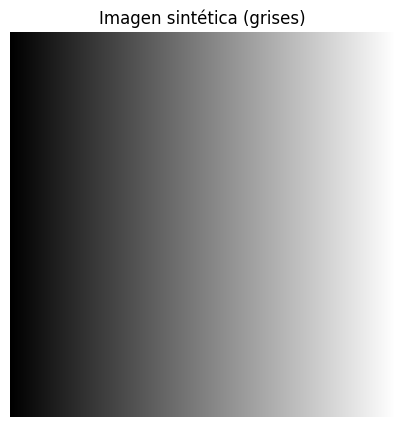

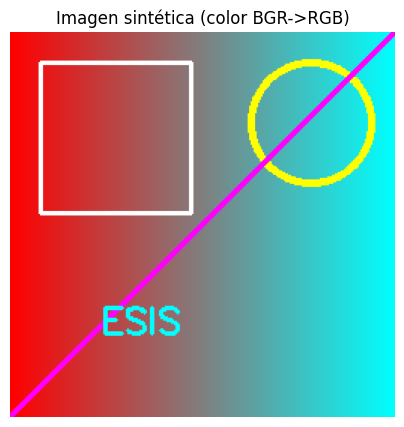

In [2]:
# Creamos una imagen sintética (degrade + figuras) para explorar pixeles y canales
h, w = 256, 256
grad = np.tile(np.linspace(0, 255, w, dtype=np.uint8), (h, 1))  # escala de grises
img_gray = grad.copy()

# Componemos una imagen BGR artificial
img_color = np.zeros((h, w, 3), dtype=np.uint8)
img_color[..., 0] = grad                    # Canal B
img_color[..., 1] = np.flipud(grad)         # Canal G
img_color[..., 2] = 255 - grad              # Canal R

# Dibujamos primitivas: rectángulo, círculo, línea y texto
cv2.rectangle(img_color, (20,20), (120,120), (255,255,255), 2)
cv2.circle(img_color, (200, 60), 40, (0,255,255), thickness=3)
cv2.line(img_color, (0,255), (255,0), (255,0,255), thickness=2)
cv2.putText(img_color, "ESIS", (60,200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

imshow_cv(img_gray, "Imagen sintética (grises)")
imshow_cv(img_color, "Imagen sintética (color BGR->RGB)")

# Pregunta 1:
¿Cómos se compuso la imágenen a colores a partir de la imágen en escala de grises y por qué aparecen los colores rojo degradado de izquierda a derecha y verde agua degradado de derecha a izquierda?

La imagen a colores se compuso a partir de la imagen en escala de grises utilizando sus valores en los distintos canales de color. El canal
azul tomó el degradado original de izquierda a derecha, el canal verde tomó ese mismo degradado pero invertido de derecha a izquierda, y el
canal rojo se creó con el negativo del degradado. Al combinarse estos tres canales, aparecen diferentes tonalidades.

Pixel BGR en (y=100, x=150): [150 150 105]
ROI shape: (70, 90, 3)
Canales: (256, 256) (256, 256) (256, 256)


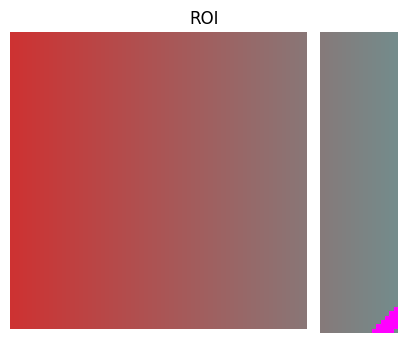

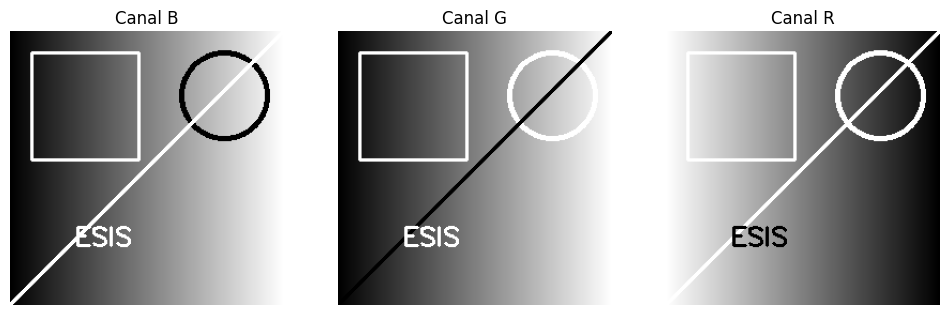

In [3]:
# Acceso a pixeles, ROI y canales
y, x = 100, 150
px_bgr = img_color[y, x]           # vector BGR
roi = img_color[50:120, 50:140]    # recorte
b, g, r = cv2.split(img_color)     # separación de canales

print("Pixel BGR en (y=100, x=150):", px_bgr)
print("ROI shape:", roi.shape)
print("Canales:", b.shape, g.shape, r.shape)

# Visualizamos ROI y canales
imshow_cv(roi, "ROI")
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(b, cmap='gray'); plt.title('Canal B'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(g, cmap='gray'); plt.title('Canal G'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(r, cmap='gray'); plt.title('Canal R'); plt.axis('off')
plt.show()

# Pregunta 2:
1. ¿Por qué en un canal (B) el circulo sale NEGRO y en los otros canales blanco?
2. ¿Por qué en un canal (G) la línea diagonal sale NEGRA y en los otros canales blanca?
3. ¿Por qué en un canal (R) la palabra ESIS sale de color negro y en los otros canales blanca?


En el caso del círculo, este se dibujó con un color que no tenía componente azul, por eso en el canal B aparece negro, mientras que en los
canales G y R sí tenía intensidad y se ve blanco. La línea diagonal fue dibujada con un color sin componente verde, por eso en el canal G
aparece negra, pero en los canales B y R se muestra blanca. por lo tanto la palabra ESIS se escribió con un color que no tenía componente
rojo, lo cual hace que en el canal R aparezca negra, mientras que en los canales B y G sí se visualice blanca.


## 2) Tipos de imágenes
**Tipos:**  
- **Binaria** (2 niveles: 0/1).  
- **Escala de grises** (1 canal).  
- **Color** (RGB/BGR de 3 canales, RGBA de 4 canales).  
- **(Mención) Multiespectral/Hiperespectral**: múltiples bandas (no trabajaremos aquí).

**Formatos:**  
- **PNG** (compresión sin pérdida, soporta transparencia).  
- **JPEG/JPG** (compresión con pérdida, controlable con calidad).  
- **BMP** (sin compresión, archivos más pesados).  
- **TIFF** (muy flexible; puede ser sin pérdida o con compresión).  
- **RAW** (salida directa del sensor; varía por dispositivo).


# 3) Formato de archivo
A continuación sube el logo de la Universidad (buscar en Google).

In [4]:
# Subir imágenes para pruebas
from google.colab import files

print("Sube el logo de la Universidad.")
uploaded = files.upload()  # dict: nombre->contenido

uploaded_paths = []
for name, data in uploaded.items():
    with open(name, 'wb') as f:
        f.write(data)
    uploaded_paths.append(name)

print("Archivos subidos:", uploaded_paths)

Sube el logo de la Universidad.


Saving unjbg.jpeg to unjbg.jpeg
Archivos subidos: ['unjbg.jpeg']


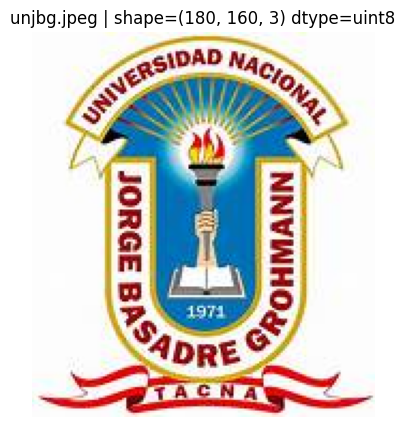

1

In [5]:
# Carga y visualización de imágenes subidas
imgs = []
for p in uploaded_paths:
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)  # preserva alfa si existe
    if img is None:
        print(f"No se pudo leer {p}")
        continue
    imgs.append((p, img))
    imshow_cv(img, f"{p} | shape={img.shape} dtype={img.dtype}")

len(imgs)

In [6]:

# Guardar en distintos formatos y comparar tamaños
os.makedirs("salidas", exist_ok=True)
report = []

for p, img in imgs:
    base = os.path.splitext(os.path.basename(p))[0]
    # Guardar PNG (sin pérdida)
    out_png = f"salidas/{base}.png"
    cv2.imwrite(out_png, img)
    size_png = os.path.getsize(out_png)

    # Guardar BMP
    out_bmp = f"salidas/{base}.bmp"
    cv2.imwrite(out_bmp, img)
    size_bmp = os.path.getsize(out_bmp)

    # Guardar TIFF
    out_tiff = f"salidas/{base}.tiff"
    cv2.imwrite(out_tiff, img)
    size_tiff = os.path.getsize(out_tiff)

    # Guardar JPEG con distintas calidades
    sizes_jpg = {}
    for q in [95, 80, 60, 40]:
        out_jpg = f"salidas/{base}_q{q}.jpg"
        cv2.imwrite(out_jpg, img, [cv2.IMWRITE_JPEG_QUALITY, q])
        sizes_jpg[q] = os.path.getsize(out_jpg)

    report.append({
        "archivo": p,
        "PNG(bytes)": size_png,
        "BMP(bytes)": size_bmp,
        "TIFF(bytes)": size_tiff,
        **{f"JPG_q{q}(bytes)": sizes_jpg[q] for q in sizes_jpg}
    })

import pandas as pd
df = pd.DataFrame(report)
print("Comparativa de tamaños (bytes):")

print(df)

Comparativa de tamaños (bytes):
      archivo  PNG(bytes)  BMP(bytes)  TIFF(bytes)  JPG_q95(bytes)  \
0  unjbg.jpeg       56051       86454        69582           17534   

   JPG_q80(bytes)  JPG_q60(bytes)  JPG_q40(bytes)  
0           10376            8072            6024  


# Pregunta 3:
1. ¿Qué diferencia hay entre los formatos PNG, BMP y JPG_qXX?
2. ¿Cuales formatos son comprimidos y cuales no?
3. ¿Cuáles formatos tienen pérdida y cuales no?
4. ¿Por qué preferir PNG por encima de JPG_q95?

La diferencia entre los formatos es que BMP no tiene ningún tipo de compresión, por lo que genera archivos muy pesados, PNG utiliza
compresión sin pérdida conservando exactamente la calidad de la imagen, y JPG aplica compresión con pérdida, donde la calidad depende
del nivel que se seleccione (por ejemplo, q95 conserva bastante, pero aún así pierde detalles). De estos, BMP no está comprimido, mientras
que PNG y JPG sí aplican compresión. En cuanto a la pérdida, BMP y PNG no la tienen, mientras que JPG sí introduce pérdida.